dat shape (neurons x trials): (39209, 5900)

Computed metrics for 500 neurons.
             count          mean           std         min           25%  \
neuron_idx   500.0  19525.856000  11244.473146  207.000000  10232.000000   
AUC          500.0      0.510782      0.057375    0.299158      0.474447   
Advantage    500.0      0.021563      0.114750   -0.401685     -0.051106   
FI_trace     500.0    277.729223     49.218465   93.026082    246.366304   
FI_along_w   500.0      0.080267      0.025346    0.029096      0.063616   
EffectiveFI  500.0      0.001954      0.009867   -0.029765     -0.003765   

                      50%           75%           max  
neuron_idx   19254.500000  29395.250000  39154.000000  
AUC              0.509632      0.546742      0.732181  
Advantage        0.019264      0.093485      0.464362  
FI_trace       275.770588    310.621339    385.446684  
FI_along_w       0.073311      0.089580      0.218260  
EffectiveFI      0.001402      0.007216      0.05034

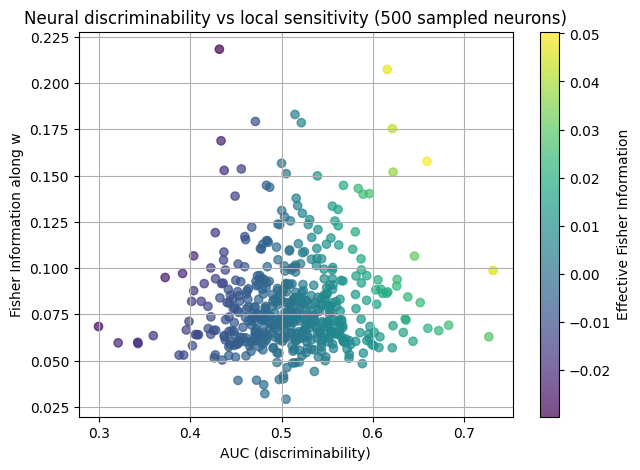


Top 10 cleanest neurons (high AUC & FI):
     neuron_idx       AUC  FI_along_w  EffectiveFI
237       11912  0.659629    0.157703     0.050348
8         10412  0.616059    0.207322     0.048123
64        28875  0.732181    0.098727     0.045845
78        32302  0.621641    0.175333     0.042655
56        28372  0.622448    0.151834     0.037184
451       29539  0.645911    0.106466     0.031069
59        26624  0.727529    0.062851     0.028601
100       27167  0.596499    0.140230     0.027064
285       20114  0.683412    0.069089     0.025343
197       37048  0.589584    0.139926     0.025070


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.exceptions import ConvergenceWarning
import pickle, warnings, random

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Load data ---
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))  # (118, 1000)
X = softmax(embeddings, axis=1)

# --- Compute trial structure ---
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

# Split images by identity (no trial leakage)
img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# --- Binarize responses ---
Y_binary = (dat > 0).astype(int)

# --- Apply CLR transform to embeddings ---
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# --- Helper functions ---
def fisher_information_from_logreg(model, X):
    p = model.predict_proba(X)[:, 1]
    w_diag = p * (1 - p)
    W = np.diag(w_diag)
    I = X.T @ W @ X / len(X)
    return I

def classifier_advantage(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    advantage = 2 * (auc - 0.5)
    return auc, advantage

# --- Randomly sample 500 neurons ---
rng = np.random.default_rng(42)
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)

results = []

# --- Main loop ---
for idx in sampled_neurons:
    y = Y_binary[idx]
    if y.sum() < 10 or y.sum() > len(y) - 10:
        continue  # skip neurons with too few or too many spikes
    
    X_train, X_test = X_trials_clr[train_mask], X_trials_clr[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        solver='liblinear'
    )
    try:
        model.fit(X_train, y_train)
    except Exception:
        continue
    
    y_prob = model.predict_proba(X_test)[:, 1]
    auc, adv = classifier_advantage(y_test, y_prob)
    
    I = fisher_information_from_logreg(model, X_train)
    w = model.coef_.ravel()
    FI_trace = np.trace(I)
    FI_along_w = float(w @ I @ w)
    
    # Effective Fisher: gate local info by correctness
    EffectiveFI = FI_along_w * (2 * auc - 1)
    
    results.append({
        "neuron_idx": idx,
        "AUC": auc,
        "Advantage": adv,
        "FI_trace": FI_trace,
        "FI_along_w": FI_along_w,
        "EffectiveFI": EffectiveFI
    })

# --- Convert to DataFrame ---
df = pd.DataFrame(results)
print(f"\nComputed metrics for {len(df)} neurons.")
print(df.describe().T)

# --- Plot AUC vs Fisher Information ---
plt.figure(figsize=(7,5))
sc = plt.scatter(df["AUC"], df["FI_along_w"], 
                 c=df["EffectiveFI"], cmap="viridis", alpha=0.7)
plt.colorbar(sc, label="Effective Fisher Information")
plt.xlabel("AUC (discriminability)")
plt.ylabel("Fisher Information along w")
plt.title("Neural discriminability vs local sensitivity (500 sampled neurons)")
plt.grid(True)
plt.show()

# --- Optional: identify cleanest neurons ---
top_clean = df.sort_values("EffectiveFI", ascending=False).head(10)
print("\nTop 10 cleanest neurons (high AUC & FI):")
print(top_clean[["neuron_idx","AUC","FI_along_w","EffectiveFI"]])



At FDR=0.05, 87/500 neurons have AUC > 0.5 (significant).


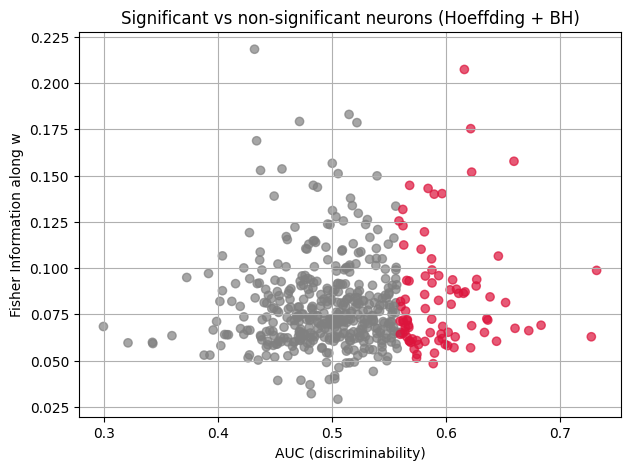


Top 10 significant neurons:
     neuron_idx       AUC       p_value         p_adj
64        28875  0.732181  1.671899e-33  8.359496e-31
59        26624  0.727529  3.339328e-32  8.348320e-30
285       20114  0.683412  3.519460e-21  5.865767e-19
107       16698  0.672602  7.699919e-19  9.624899e-17
110       29247  0.660549  2.127513e-16  2.127513e-14
237       11912  0.659629  3.213514e-16  2.677929e-14
20          864  0.652259  8.026444e-15  5.733174e-13
451       29539  0.645911  1.135976e-13  7.099851e-12
51        11782  0.644304  2.182419e-13  1.212455e-11
141         702  0.638611  2.080526e-12  1.040263e-10


In [2]:
from statsmodels.stats.multitest import multipletests
import numpy as np

# --- Parameters for Hoeffding bound ---
m = n = 28 * 50  # approximate positives/negatives per neuron
# if each neuron saw all test stimuli, m ≈ n = 28 images × 50 trials each
# adjust if your test split changes

def hoeffding_pvalue(auc, m, n):
    """One-sided conservative p-value for H0: AUC <= 0.5."""
    delta = max(auc - 0.5, 0)  # only one-sided excess matters
    if delta <= 0:
        return 1.0
    exponent = -2 * delta**2 / (1/m + 1/n)
    return float(np.exp(exponent))

# --- Compute p-values per neuron ---
df["p_value"] = df["AUC"].apply(lambda x: hoeffding_pvalue(x, m, n))

# --- Benjamini–Hochberg FDR correction ---
alpha = 0.05  # desired FDR level
reject, pvals_corrected, _, _ = multipletests(df["p_value"], alpha=alpha, method="fdr_bh")

df["p_adj"] = pvals_corrected
df["significant"] = reject

# --- Summary ---
n_signif = df["significant"].sum()
print(f"\nAt FDR={alpha}, {n_signif}/{len(df)} neurons have AUC > 0.5 (significant).")

# --- Optional: visualize significance ---
plt.figure(figsize=(7,5))
plt.scatter(df["AUC"], df["FI_along_w"], 
            c=df["significant"].map({True:'crimson', False:'gray'}),
            alpha=0.7, label='neurons')
plt.xlabel("AUC (discriminability)")
plt.ylabel("Fisher Information along w")
plt.title("Significant vs non-significant neurons (Hoeffding + BH)")
plt.grid(True)
plt.show()

# --- Inspect top neurons ---
sig_neurons = df[df["significant"]].sort_values("AUC", ascending=False)
print("\nTop 10 significant neurons:")
print(sig_neurons.head(10)[["neuron_idx", "AUC", "p_value", "p_adj"]])


In [3]:
# Inside your main loop, after computing auc, adv, etc.
m_pos = y_test.sum()
n_neg = len(y_test) - m_pos

results.append({
    "neuron_idx": idx,
    "AUC": auc,
    "Advantage": adv,
    "FI_trace": FI_trace,
    "FI_along_w": FI_along_w,
    "EffectiveFI": EffectiveFI,
    "m_pos": m_pos,
    "n_neg": n_neg
})

from statsmodels.stats.multitest import multipletests
import numpy as np

def hoeffding_pvalue(auc, m, n):
    """One-sided conservative p-value for H0: AUC <= 0.5."""
    delta = max(auc - 0.5, 0)
    if delta <= 0 or m == 0 or n == 0:
        return 1.0
    exponent = -2 * delta**2 / (1/m + 1/n)
    return float(np.exp(exponent))

# --- Compute per-neuron p-values using actual class counts ---
df["p_value"] = [
    hoeffding_pvalue(auc, m, n)
    for auc, m, n in zip(df["AUC"], df["m_pos"], df["n_neg"])
]

# --- BH correction (FDR) ---
alpha = 0.05
reject, pvals_corrected, _, _ = multipletests(df["p_value"], alpha=alpha, method="fdr_bh")

df["p_adj"] = pvals_corrected
df["significant"] = reject

# --- Summary and plots ---
n_signif = df["significant"].sum()
print(f"\nAt FDR={alpha}, {n_signif}/{len(df)} neurons have AUC > 0.5 (significant).")

plt.figure(figsize=(7,5))
plt.scatter(df["AUC"], df["FI_along_w"],
            c=df["significant"].map({True: "crimson", False: "gray"}),
            alpha=0.7)
plt.xlabel("AUC (discriminability)")
plt.ylabel("Fisher Information along w")
plt.title("Significant vs non-significant neurons (Hoeffding + BH, imbalance-corrected)")
plt.grid(True)
plt.show()

sig_neurons = df[df["significant"]].sort_values("AUC", ascending=False)
print("\nTop 10 significant neurons (imbalance-corrected):")
print(sig_neurons.head(10)[["neuron_idx", "AUC", "m_pos", "n_neg", "p_value", "p_adj"]])


KeyError: 'm_pos'

dat shape (neurons x trials): (39209, 5900)

Computed metrics for 500 neurons.
At FDR=0.05, 1/500 neurons show AUC > 0.5 (significant).


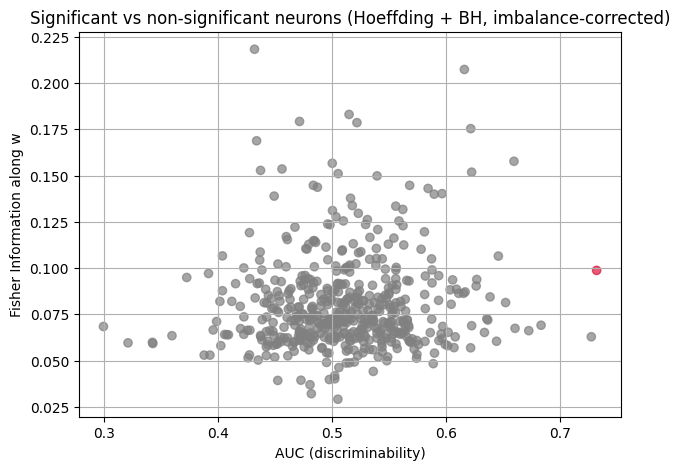


Summary statistics:
                     mean           std          min           max
neuron_idx   19525.856000  11244.473146   207.000000  39154.000000
AUC              0.510782      0.057375     0.299158      0.732181
Advantage        0.021563      0.114750    -0.401685      0.464362
FI_trace       277.729223     49.218465    93.026082    385.446684
FI_along_w       0.080267      0.025346     0.029096      0.218260
EffectiveFI      0.001954      0.009867    -0.029765      0.050348
m_pos           68.450000     52.662645    12.000000    367.000000
n_neg         1331.550000     52.662645  1033.000000   1388.000000
p_value          0.862886      0.230591     0.000024      1.000000
p_adj            0.996803      0.048166     0.011796      1.000000

Top 10 significant neurons (imbalance-corrected):
    neuron_idx       AUC  m_pos  n_neg   p_value     p_adj
64       28875  0.732181    107   1293  0.000024  0.011796

Top 10 cleanest neurons (high AUC & FI):
     neuron_idx       AUC  FI_a

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.exceptions import ConvergenceWarning
from statsmodels.stats.multitest import multipletests
import pickle, warnings

# ---------------------------------------------------------------
#  Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)

# ---------------------------------------------------------------
#  Load data
# ---------------------------------------------------------------
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))          # (118, 1000)
X = softmax(embeddings, axis=1)                # convert to probabilities

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

# Split by image identity (avoid leakage across trials)
img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# ---------------------------------------------------------------
#  Transform data
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)        # spike indicator
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# ---------------------------------------------------------------
#  Helper functions
# ---------------------------------------------------------------
def fisher_information_from_logreg(model, X):
    """Compute Fisher Information matrix for fitted logistic regression."""
    p = model.predict_proba(X)[:, 1]
    W = np.diag(p * (1 - p))
    return X.T @ W @ X / len(X)

def classifier_advantage(y_true, y_prob):
    """Return AUC and classifier advantage (2*(AUC-0.5))."""
    auc = roc_auc_score(y_true, y_prob)
    return auc, 2 * (auc - 0.5)

def hoeffding_pvalue(auc, m, n):
    """One-sided conservative p-value for H0: AUC <= 0.5."""
    delta = max(auc - 0.5, 0)
    if delta <= 0 or m == 0 or n == 0:
        return 1.0
    exponent = -2 * delta**2 / (1/m + 1/n)
    return float(np.exp(exponent))

# ---------------------------------------------------------------
#  Run per-neuron logistic regressions
# ---------------------------------------------------------------
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    if y.sum() < 10 or y.sum() > len(y) - 10:
        continue  # skip too imbalanced neurons

    X_train, X_test = X_trials_clr[train_mask], X_trials_clr[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        solver='liblinear'
    )

    try:
        model.fit(X_train, y_train)
    except Exception:
        continue

    y_prob = model.predict_proba(X_test)[:, 1]
    auc, adv = classifier_advantage(y_test, y_prob)

    I = fisher_information_from_logreg(model, X_train)
    w = model.coef_.ravel()
    FI_trace = np.trace(I)
    FI_along_w = float(w @ I @ w)
    EffectiveFI = FI_along_w * (2 * auc - 1)

    m_pos = y_test.sum()
    n_neg = len(y_test) - m_pos
    p_val = hoeffding_pvalue(auc, m_pos, n_neg)

    results.append({
        "neuron_idx": idx,
        "AUC": auc,
        "Advantage": adv,
        "FI_trace": FI_trace,
        "FI_along_w": FI_along_w,
        "EffectiveFI": EffectiveFI,
        "m_pos": m_pos,
        "n_neg": n_neg,
        "p_value": p_val
    })

# ---------------------------------------------------------------
#  Analysis: Benjamini–Hochberg correction
# ---------------------------------------------------------------
df = pd.DataFrame(results)
print(f"\nComputed metrics for {len(df)} neurons.")

alpha = 0.05
reject, pvals_corrected, _, _ = multipletests(df["p_value"], alpha=alpha, method="fdr_bh")
df["p_adj"] = pvals_corrected
df["significant"] = reject

n_sig = df["significant"].sum()
print(f"At FDR={alpha}, {n_sig}/{len(df)} neurons show AUC > 0.5 (significant).")

# ---------------------------------------------------------------
#  Visualization
# ---------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(df["AUC"], df["FI_along_w"],
            c=df["significant"].map({True:"crimson", False:"gray"}),
            alpha=0.7)
plt.xlabel("AUC (discriminability)")
plt.ylabel("Fisher Information along w")
plt.title("Significant vs non-significant neurons (Hoeffding + BH, imbalance-corrected)")
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
#  Reports
# ---------------------------------------------------------------
print("\nSummary statistics:")
print(df.describe().T[["mean","std","min","max"]])

sig_neurons = df[df["significant"]].sort_values("AUC", ascending=False)
print("\nTop 10 significant neurons (imbalance-corrected):")
print(sig_neurons.head(10)[["neuron_idx", "AUC", "m_pos", "n_neg", "p_value", "p_adj"]])

top_clean = df.sort_values("EffectiveFI", ascending=False).head(10)
print("\nTop 10 cleanest neurons (high AUC & FI):")
print(top_clean[["neuron_idx","AUC","FI_along_w","EffectiveFI"]])
